In [1]:
import numpy as np 
from sklearn import linear_model
from tqdm import tqdm
import matplotlib.pyplot as plt
# for my supacool dark theme:
plt.style.use('dark_background')

## Real data

In [2]:
path2data= ''
'''A_raw = pd.readcsv(path2data + )
x_raw =prd.readcsv(path2data + )
y_raw =prd.readcsv(path2data + )'''

'A_raw = pd.readcsv(path2data + )\nx_raw =prd.readcsv(path2data + )\ny_raw =prd.readcsv(path2data + )'

## Simulated data

In [ ]:
# simul_data:
# return a random sample of  coefficients with s 
## Input: n, p, h2
## output y, A, x_true
y, A, x_true = simul_data(n, p, h2)

In [4]:
# test purpose
nt = 100
pt = 500
st = 90
At = np.random.normal(size=(nt, pt))

In [5]:
'''# Simulate Phenotype y given a genotype matrix A
Input:  A, genotype matrix (either real or simulated data)
        s, sparsity of the x vector (number of non zeros coeffs)
        h2, heritability (ratio of the phenotype explained by the genotype)
        xtype, in ['uniform', 'hyperExp'(not coded yet)], type of coefficients simulated 
'''
def genPhenotype(A, s, h2 = 1, xtype = 'uniform'):
    n = A.shape[0]
    p = A.shape[1]
    x = np.ones(p)
    if xtype == 'hyperExp':
        x = np.exp(-(np.arange(p) + 1) / (.05*s)) + np.exp(-(np.arange(p)+1)/p)
    # set s coefficients to zeros
    x_mask = np.random.choice(np.arange(p), p-s, replace= False)
    x[x_mask] = 0
    np.random.shuffle(x_mask)
    # heritability
    x = np.sqrt(h2) * x / np.std(A.dot(x))
    e = np.sqrt(1-h2) * np.random.normal(n)
    y = A.dot(x) + e
    return x, y

#genPhenotype(At, st)

## Recovery algorithm: Linear regression with Lasso

We solve the following minimisation problem using scikit-learn : 
$$min_x [\Vert y -Ax \Vert_{L_2}^2+\lambda \Vert x \Vert_{L_1}]$$

In [6]:
def lasso(A, y, lambd = 0.1, normalize = True):
    """return the coefficient of the lasso regression of A over y, lambd is the regulizer parameter
    """
    reg = linear_model.Lasso(lambd, normalize = normalize)
    reg.fit(A, y)
    return reg.coef_

## Phase-transition 

In [7]:
# for the simulated assays
def phase_transition_mat(A, h2 = 1, xtype = 'uniform', size = 10, nb_steps = 100):
    """return return a size by size matrix with the NE score for the lasso reconstruction procedure 
    A : measurement matrix (genotype)
    x_true : true coefficients
    y : phenotype
    size : the size of the phase transition matrix
    """
    # number of samples
    n = A.shape[0]
    # number of SNPs
    p = A.shape[1]
    PTM = np.zeros((size, size))
    
    for step in tqdm(range(nb_steps)):
        # non zeros coefficients in the true x vector
        s = np.random.randint(p) + 1
        x, y = genPhenotype(A=A, s=s, h2=h2, xtype=xtype)
        # we range over a number of samples
        for n_tmp in n//nb_steps + np.arange(n, step=n//nb_steps):
            delta = n_tmp / p
            if delta == 1:
                delta-=0.001
            rho = s / n_tmp
            if rho < 1:
                ix = np.arange(n)
                # select eandomly a subset of individuals
                ix_tmp = np.random.choice(ix, n_tmp)
                #print(A[ix_tmp,].shape, y[ix_tmp].shape)
                #print(delta, rho)
                x_pred = lasso(A[ix_tmp,], y[ix_tmp], lambd = .01)
                #print(delta*size, rho*size)
                #print(rho, delta)
                #print(size - np.ceil(rho*size), np.floor(delta*size))
                PTM[int(np.floor(rho*size)),int(np.floor(delta*size))] = np.linalg.norm(x-x_pred)/np.linalg.norm(x)
        step+=1
    return PTM

In [8]:
PTM = phase_transition_mat(At, h2 = 1)
PTM

 90%|█████████ | 90/100 [00:02<00:00, 38.74it/s]/home/matthieu/virtualenvs/python3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
100%|██████████| 100/100 [00:02<00:00, 36.31it/s]


array([[ 0.09868313,  0.16023931,  0.15035714,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09672739,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.0828787 ,  0.91291422,  1.00210487,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.04653007,  0.93396133,  0.9491415 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.17778144,  0.97987011,  1.01813159,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.0778701 ,  1.03329205,  0.95416729,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.04256125,  1.03491504,  1.02485015,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

# Plot the matrix of transition

In [9]:
def frontier(mat, thres):
    """construction of the phase transition frontier, i.e. first time the NE score is below the thres value"""
    L = []
    N = len(mat)
    for s in range(int(N)):
        P = 0
        while mat[P,s]<thres and P<N-1:
            P = P + 1
        L.append(P)
    return L

In [10]:
def plot_transition(M, thres = 0.5, save = False):
    size = M.shape[0]
    #rho_min, rho_max, delta_min, delta_max = 0, size, 0, size
    fig = plt.imshow(M, interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent = [0, size, 0, size])
    plt.xlabel(r'$\delta = \frac{n}{p}$')
    plt.ylabel(r'$\rho = \frac{s}{n}$')

    #empirical phase transition
    X = range(size)
    L = frontier(M, thres = thres)
    plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
    plt.legend(loc=4)
    cax = plt.axes([1, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    plt.show()
    if save == True:
        filename = 'transition_matrix.png'
        plt.savefig(filename,bbox_inches='tight')

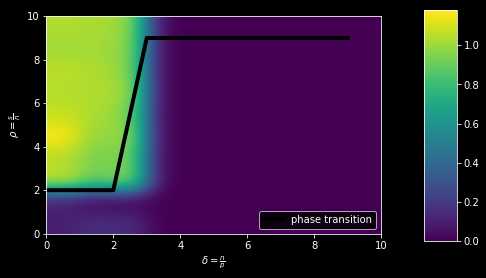

In [11]:
plot_transition(PTM)

## Recovery measures:

We implemented the different recovery measures developped in the paper:

* **PPV**, Positive Predicted Value: the ratio between the number of True Positive and the number of selected Positive coefficients (i.e. the number of non-zero coefficients: $\frac{\#\{x_i : x_i\neq 0;\hat x_i \neq 0\}}{\#\{\hat x_i:\hat x_i \neq 0\}}$

* **FPR**, False Positive Rate: the ratio between the number of False Positive and the total number of Negative coefficients (i.e. the number of zero coefficients): $\frac{\#\{x_i : x_i = 0;\hat x_i \neq 0\}}{\#\{x_i:x_i = 0\}}$ 

* **$med_{P-val}$**, the median of the P-values obtained when regressing the phenotypes on each selected SNP. For each of this regression, we compute the p-value associated to the t-test asserting if the coefficient of the regression is zero. We then take the median of these p-values. Note that, contrary to the other measures of recovery, this one could be computed in real experiments where we don't have access to the true coefficients x.

In [14]:
import statsmodels.formula.api as sm

# positive predictive value
def PPV(x, x_hat):
    nb_tp = np.sum([1 for u,v in zip(x, x_hat) if (u != 0) and (v != 0)])
    nb_pos = np.sum([1 for e in x_hat if e!=0])
    assert nb_pos !=0, 'Error, x is null!'
    return nb_tp/nb_pos

def FPR(x, x_hat):
    nb_fp = np.sum([1 for u,v in zip(x, x_hat) if (u==0) and (v!=0)])
    nb_neg = np.sum([1 for e in x if e==0])
    assert nb_neg !=0, 'Error, x is not sparse!'
    return nb_fp/nb_neg

def med_P(x_hat, y, A):
    p_vals = []
    for i in np.arange(len(y)):
        if x_hat[i] != 0:
            snp = A[:,i]
            reg = sm.OLS(y, snp).fit()
            p_vals.append(reg.t_test([1]).pvalue) 
    measure = np.median(np.array(p_vals))
    print('{} selected non zero coefficients (over {} total number of SNPs)'.format(len(p_vals), len(x_hat)))
    return measure

In [15]:
xt, yt = genPhenotype(At, 90)
x_hatt = lasso(A=At, y=yt, lambd = 0.001)
#print(x_hatt)
med_P(x_hatt, yt, At)

16 selected non zero coefficients (over 500 total number of SNPs)


0.14430416186780062